In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import geopandas as gpd
import cartopy.crs as ccrs

#%% Global plotting settings
rcParams['font.family'] = 'Bitstream Vera Sans'
rcParams['font.size'] = 10

crs_choice = 'orthographic'

# Number of bins for colourmap
#categories = 6

#%% Importing Geodata and changing crs
geodata = gpd.read_file('world-administrative-boundaries')

#%% Geodata and change of crs

if crs_choice == 'mercator': 
    geodata = geodata.to_crs(epsg=3395) # classic mercator
elif crs_choice == 'WGS84': 
    geodata = geodata.to_crs(epsg=4326) # WGS84 Web Mercator Auxiliary Sphere, coordinates in meters
elif crs_choice == 'mollweide': 
    geodata = geodata.to_crs(epsg=54009) # Mollweide Equal Area Cylindrical projection
elif crs_choice == 'robinson': 
    geodata = geodata.to_crs(ccrs.Robinson().proj4_init)
    robinson = ccrs.Robinson().proj4_init
elif crs_choice == 'orthographic':
    # Define the CartoPy CRS object.
    # the arguments define where the central point of the plot is on the globe 
    # -> determines how the curvature looks! 
    # E.g.: Africa central point -> Europe shown as strong curvature at top of the globe only
    crs = ccrs.Orthographic(central_longitude=10, central_latitude=50) 

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    geodata = geodata.to_crs(crs_proj4)

In [2]:
#Population data, country-level
year = '2018'
eu_labels = ['AUT',
 'BEL',
 'BGR',
 'HRV',
 'CYP',
 'CZE',
 'DNK',
 'EST',
 'FIN',
 'FRA',
 'DEU',
 'GRC',
 'HUN',
 'IRL',
 'ITA',
 'LVA',
 'LTU',
 'LUX',
 'MLT',
 'NLD',
 'POL',
 'PRT',
 'ROU',
 'SVK',
 'SVN',
 'ESP',
 'SWE'] #EU27 (as of 2020) countries in ISO3 format

pop_all = pd.read_csv('data/population.txt', sep='\t', index_col=[0, 1, 2], header=0)
pop_all.index = pop_all.index.get_level_values(1)
pop_eu = pop_all.loc[eu_labels]

gini = pd.read_csv('processed_data/x_crow_sub_eu_icio_agg.csv', index_col=0) 
gini = gini*1e6#/1000 #conversion to Billion USD

gini = gini.div(pop_eu[year], axis=0)
gini.index.rename('region', inplace=True)
structure_list = gini.columns.to_list()
gini.reset_index(inplace=True)

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')


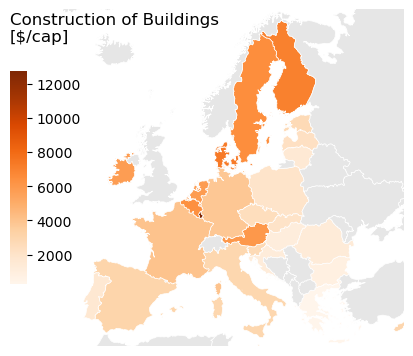

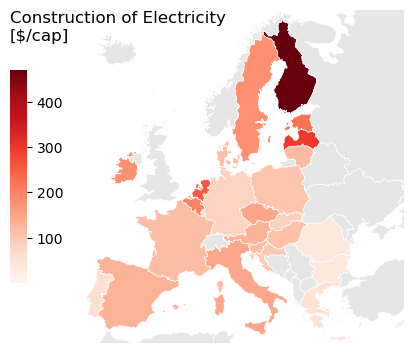

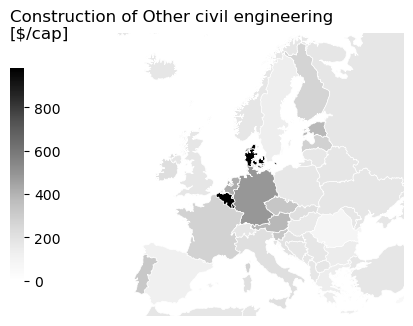

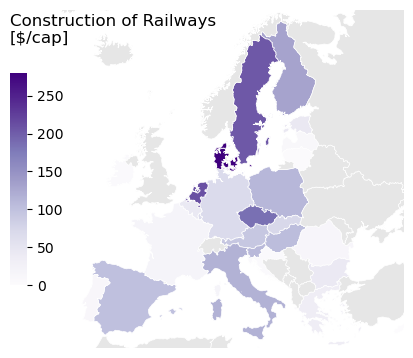

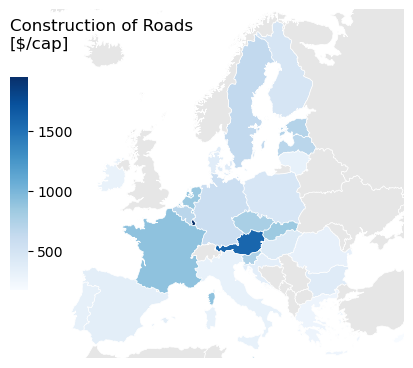

In [3]:
for structure, colormap in dict(zip(structure_list, ['Oranges', 'Reds', 'Greys', 'Purples', 'Blues'])).items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[$/cap]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_totaloutput_eu_'+structure+year+'pop.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

In [2]:
#physical total output, maps
gini = pd.read_csv('processed_data/x_crow_sub_phys.csv', index_col=[0,1,2,3,4,5]) 
gini = gini.xs(2018, level=5)
gini[gini<0] = 0
gini.unstack(level=2).groupby(axis=0, level=[2,3]).sum()

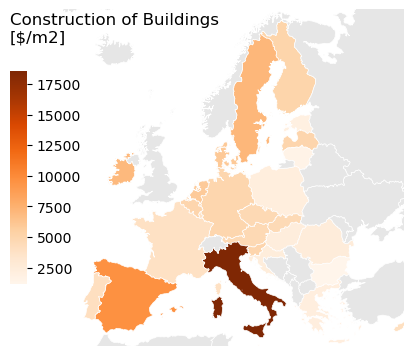

In [4]:
#prices of structure construction, maps
year = '2018'

fd = pd.read_csv('processed_data/x_crow_sub_phys_long.csv')
fd_buildings = fd[(fd['Structure']=='Buildings')&(fd['Value_process'].isin(['expansion', 'replacement']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) # €/m2
fd_buildings.index.rename('region', inplace=True)

gini = pd.read_csv('processed_data/x_crow_sub_eu_icio_agg.csv', index_col=0)
gini = gini*1e6 #conversion to USD

gini = gini.div(fd_buildings[int(year)], axis=0)
gini.index.rename('region', inplace=True)
gini = gini['Buildings']
gini = gini.reset_index()

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')

for structure, colormap in {'Buildings':'Oranges'}.items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[$/m2]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_prices_eu_'+structure+year+'withITA.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

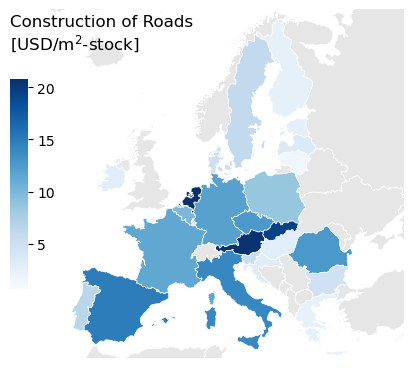

In [12]:
#prices of structure construction, maps
year = '2018'

fd = pd.read_csv('processed_data/x_crow_sub_phys_long.csv')
fd_buildings = fd[(fd['Structure'].isin(['Roads, communal', 'Roads, provincial','Roads, state','Roads, motorway']))&(fd['Value_process'].isin(['stock-area']))].groupby(by=['Country', 'Year'],sort=False).sum(numeric_only=True).unstack(1).droplevel(0, axis=1) # €/km
fd_buildings.index.rename('region', inplace=True)

gini = pd.read_csv('processed_data/x_crow_sub_eu_icio_agg.csv', index_col=0)
gini = gini #conversion to Billion USD

gini = gini.div(fd_buildings[int(year)], axis=0)
gini.index.rename('region', inplace=True)
gini = gini['Roads'].drop('LUX')
gini = gini.reset_index()

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')

for structure, colormap in {'Roads':'Blues'}.items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[USD/m$^2$-stock]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_prices_eu_'+structure+year+'_withoutLUX.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

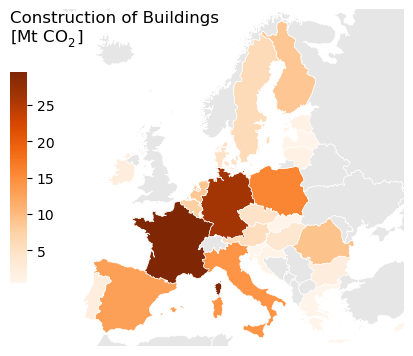

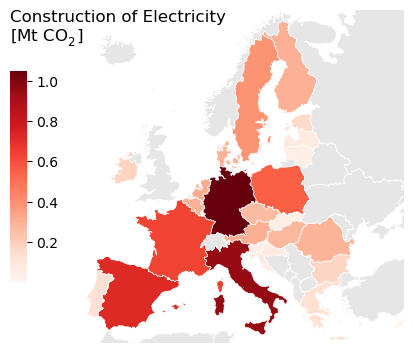

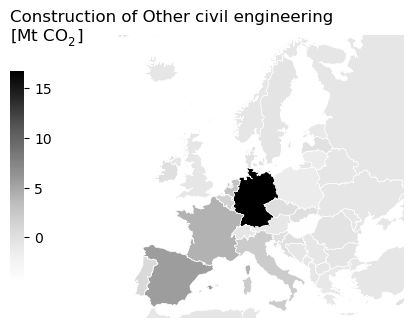

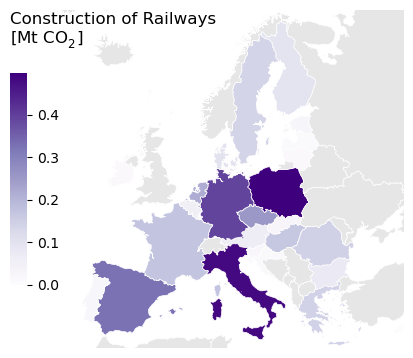

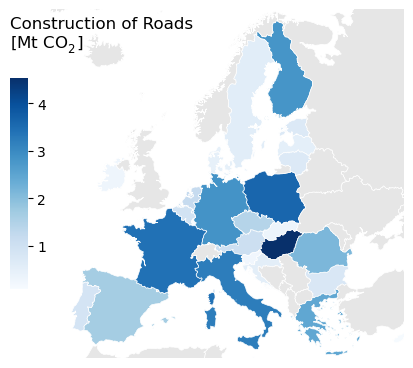

In [3]:
#footprint largest contributor per region per capita per subsector

e_sub_eu = pd.read_csv('processed_data/e_sub_eu_agg.csv', index_col=0, header=[0,1,2])
gini = e_sub_eu.loc['PROD_CO2', pd.IndexSlice[eu_labels,'Construction',:]].unstack(2).droplevel('sector', axis=0)
#gini = gini*1e9 #kg/cap/year
#gini = gini.div(pop_eu[year], axis=0)
structure_list = gini.columns.to_list()
gini.reset_index(inplace=True)

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')


for structure, colormap in dict(zip(structure_list, ['Oranges', 'Reds', 'Greys', 'Purples', 'Blues'])).items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[Mt $\mathregular{CO_2}$]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_footprint_c_eu_'+structure+year+'.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

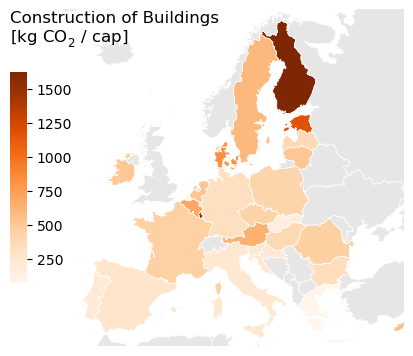

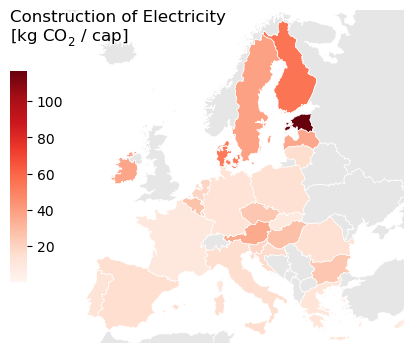

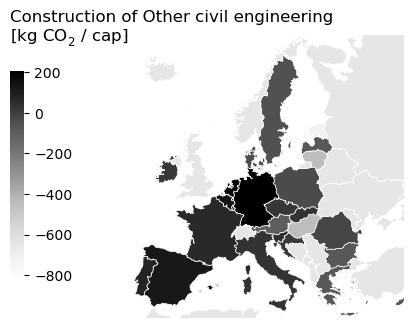

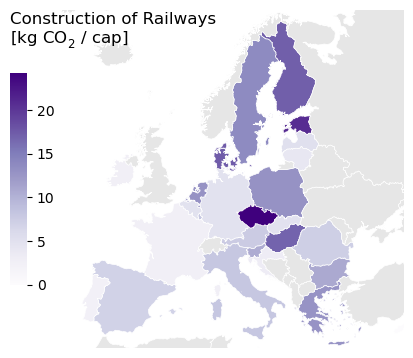

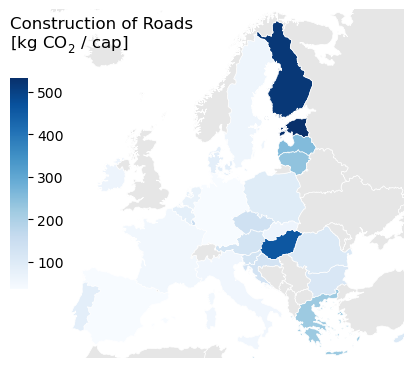

In [4]:
#footprint largest contributor per region per capita per subsector

e_sub_eu = pd.read_csv('processed_data/e_sub_eu_agg.csv', index_col=0, header=[0,1,2])
gini = e_sub_eu.loc['PROD_CO2', pd.IndexSlice[eu_labels,'Construction',:]].unstack(2).droplevel('sector', axis=0)
gini = gini*1e9 #kg/cap/year
gini = gini.div(pop_eu[year], axis=0)
structure_list = gini.columns.to_list()
gini.reset_index(inplace=True)

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')


for structure, colormap in dict(zip(structure_list, ['Oranges', 'Reds', 'Greys', 'Purples', 'Blues'])).items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[kg $\mathregular{CO_2}$ / cap]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_footprint_c_eu_'+structure+year+'pop.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

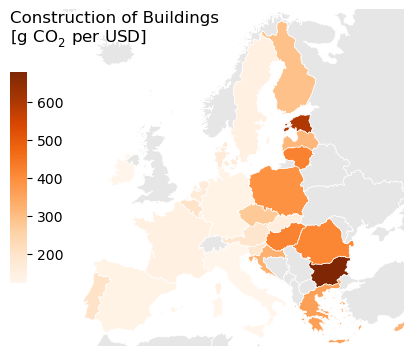

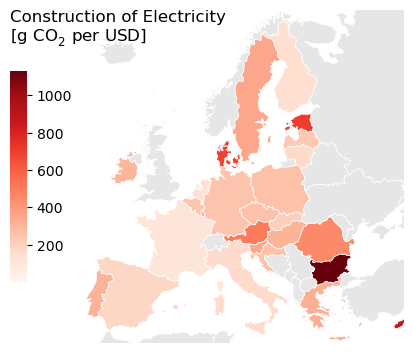

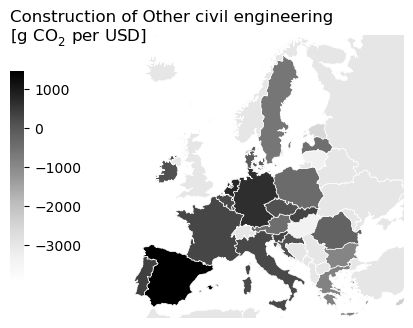

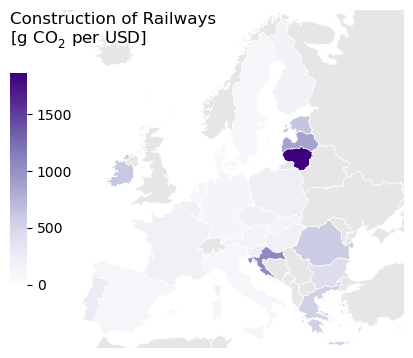

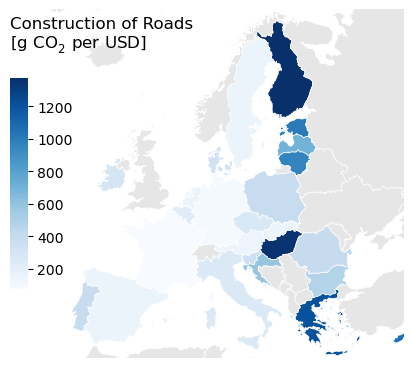

In [5]:
#multiplier largest contributor per region per capita per subsector

gini = pd.read_csv('processed_data/mult_sector_sub_agg.csv', index_col=0, header=[0,1,2])
gini = gini.loc['PROD_CO2', pd.IndexSlice[eu_labels,'Construction',:]].unstack(2).droplevel('sector', axis=0)
gini = gini*1e6 #g/$
#gini = gini.div(pop_eu[year], axis=0)
structure_list = gini.columns.to_list()
gini.reset_index(inplace=True)

#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')

for structure, colormap in dict(zip(structure_list, ['Oranges', 'Reds', 'Greys', 'Purples', 'Blues'])).items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Construction of '+structure+'\n[g $\mathregular{CO_2}$ per USD]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_multiplier_c_eu_'+structure+year+'.svg', bbox_inches='tight', pad_inches=0)
    plt.show()

In [47]:
# icio x_crow
eur_to_usd = 1.18 #from euros to usd in 2018

sbs = pd.read_csv('processed_data/sbs_construction.csv', index_col=0)[year]*eur_to_usd
sbs.rename('Construction', inplace=True)
icio = pd.read_csv('processed_data/x_crow.csv', index_col=0, header=[0,1,2]).squeeze()[eu_labels]
icio.rename('Construction', inplace=True)

gini = (sbs.div(icio)).reset_index()
gini.columns = ['region', 'Construction']

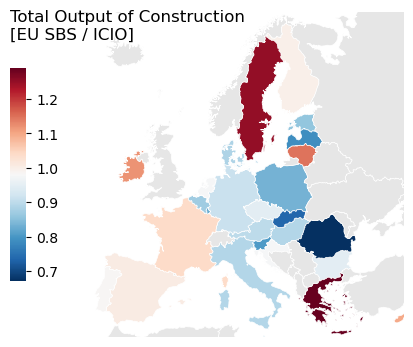

In [56]:
#%% Merging shapefiles and data
gini_europe_geo = geodata.merge(gini, left_on='iso3', right_on='region', how='left')

for structure, colormap in {'Construction':'RdBu_r'}.items():
    sequential_cmap = colormaps[colormap]

    vmin = gini_europe_geo[structure].min()
    vmax = gini_europe_geo[structure].max()
    #cmap = ListedColormap(sequential_cmap(np.linspace(0, 1, categories)))
    #custom_bins = np.linspace(vmin, vmax, categories)

    # Setting up figure and grid for subplots
    fig = plt.figure(figsize=(10/2.54, 12/2.54), facecolor='white')
    gs = GridSpec(4, 2, width_ratios=[0.05, 1], height_ratios=[1, 1, 1, 1])

    # Subplot for the colourmap
    ax2 = plt.subplot(gs[:, 1])

    # Plot the first map on the first and second columns
    plot = gini_europe_geo.plot(ax=ax2, 
                                column=structure, 
                                cmap=sequential_cmap, 
                                legend=False, linewidth=0.5, 
                                edgecolor='1', 
                                missing_kwds={'color': '0.9', 'label': 'No Data'})

    ax2.set_axis_off()

    # Adjusting x and ylim based on crs to show only Europe
    if crs_choice == 'mercator': 
        ax2.set_xlim(-1500000, 4500000)
        ax2.set_ylim(4000000, 11500000)
    elif crs_choice == 'WGS84': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'mollweide': 
        ax2.set_xlim(-15, 35)
        ax2.set_ylim(35, 75)
    elif crs_choice == 'robinson': 
        ax2.set_xlim(-990000, 3500000)
        ax2.set_ylim(3750000, 7500000)
    elif crs_choice == 'orthographic':
        ax2.set_xlim(-1900000, 2100000)
        ax2.set_ylim(-1550000, 2400000)


    # Subplot for the colourbar on the left
    ax3 = plt.subplot(gs[1:3, 0])
    #ax3.set_title('Construction of '+structure+'\n[billion $]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    ax3.set_title('Total Output of '+structure+'\n[EU SBS / ICIO]', x=0, y=1.1, ha='left') #,\ntotal output in '+year+',\nbillion  US$'
    cax = ax3

    # Create a colorbar axis for the left column
    sm = plt.cm.ScalarMappable(cmap=sequential_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # fake up the array of the scalar mappable
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical') #, format=lambda x, _: f"${x:.1e}")
    cbar.outline.set_alpha(0)

    # Adjust layout
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.8, 
                        top=0.4,
                        wspace=0, 
                        hspace=0)
    plt.tight_layout(pad=0)

    # Save and show
    plt.savefig('images/map_x_crow_sbs_icio_difference_eu_'+structure+year+'.svg', bbox_inches='tight', pad_inches=0)
    plt.show()